# BASIC (40%)
## A Linear Classifier

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For loading popular data sets
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from torch.utils.data.dataloader import DataLoader

##### Download Dataset

In [3]:
# Normalization
# Channel wise mean and standard deviation of the image

transform=transforms.Compose([transforms.RandomCrop(32, padding=4,padding_mode='reflect'), 
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(2.8),
                              transforms.RandomGrayscale(0.2),
                              transforms.ToTensor(),  # Convert images to Tensor ( Channel X Height X Width)
                              transforms.Normalize((0.4911, 0.4820, 0.4467),(0.2022, 0.1993, 0.2009)) 
                             ])

# Download training data
train = torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)


# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=transform)



from torch.utils.data.dataloader import DataLoader
 
 # Define validation ratio 
validation_ratio= 0.2
batch_size = 32

# split training data in train and validation set
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), 
                                              int((validation_ratio)*len(train))])

print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=1000,shuffle=False,pin_memory=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
40000
10000


##### Move device to GPU


In [4]:
# Check if your system has cuda gpu or only cpu

def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

# BASIC (40%)
##### Theory for Normalizing (mean and std)

In [5]:
mean=0.
std=0.
total_image_count=0
for images,labesl in train_loader:
    image_count_per_batch=images.size(0)
    # Resizing the image from 2D to 1D
    images=images.view(image_count_per_batch,images.size(1),-1)
    
    # Calculate sum of mean
    mean=mean+images.mean(2).sum(0)
    
    #Calculate sum of std
    std=std+images.std(2).sum(0)
    
    # Increment image count to get total number of images
    total_image_count=total_image_count+image_count_per_batch
    
# Mean
mean=mean/total_image_count
std=std/total_image_count
    
print(mean)
print(std)

tensor([0.0485, 0.0129, 0.0058])
tensor([0.9883, 0.9916, 0.9954])


# BASIC (40%)
#### Exploratory Data Analysis

In [6]:
# Dimentions of Batch ([No. of batches, channels, width , height ])
# Labels ([no of labels per batch])
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


## View Dataset for each batch

tensor([71, 17, 20, 62, 35, 77, 82, 32,  2, 30, 60, 22, 83, 39, 73, 72, 65, 67,
        88, 57, 49, 41, 74, 44, 26, 75, 87, 47, 52, 48,  0, 77])


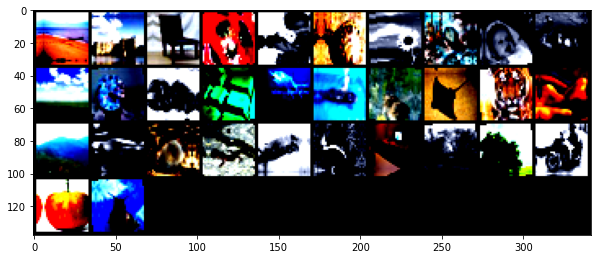

In [7]:
# This will show no. of images in a batch = 32
# hence 32 images will be shown

def show_batch(dataloader):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    for images,labels in dataloader:
        fix,ax=plt.subplots(figsize=(10,10))
        
        # imshow takes image as HxWxC hence we have to permute
        # here, 1= height, 2= width, 0= channel
        ax.imshow(make_grid(images,10).permute(1,2,0))
        print(labels)
        
        # We need to see 10 images from 1 batch => use break
        break
        
show_batch(train_loader)

# BASIC (40%)
### Linear Model

In [21]:
class Linear_ANN(nn.Module):
    def __init__(self):
        super(Linear_ANN, self).__init__()
        self.layer_1 = nn.Linear(in_features=32*32*3,out_features=1536)
        self.hidden_layer = nn.Linear(1536, 768)
        self.output_layer = nn.Linear(768, 100)
    
    def forward(self, ip):

        output = ip.view(-1, 32*32*3)
        output = self.layer_1(output)
        output = self.hidden_layer(output)
        output=self.output_layer(output)
        
        return output
    
model=Linear_ANN()
model


Linear_ANN(
  (layer_1): Linear(in_features=3072, out_features=1536, bias=True)
  (hidden_layer): Linear(in_features=1536, out_features=768, bias=True)
  (output_layer): Linear(in_features=768, out_features=100, bias=True)
)

#### Training

In [22]:
def accuracy(predicted,labels):
    pred, predclassid=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predclassid==labels).item()/len(predicted))

def evaluate(model1,dl,loss_func):
    model1.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model1(images)
        batch_losses.append(loss_func(predicted,labels))
        batch_accs.append(accuracy(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model1,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    
    optimizer=optim(model1.parameters(), max_lr, momentum=0.9)
    
    results=[]
    for epoch in range(epochs):
        model1.train()
        train_losses=[]
        train_batch_accs=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model1(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_batch_accs.append(accuracy(predicted,labels))

        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model1,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
        
    return results


model=move_device(model,device)
epochs = 20

'''
Learning Rates
'''

max_lr = 1e-2


loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''

results= train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim)

Number of epochs: 0 | Validation loss : 4.208994388580322  | Training loss : 4.356310844421387  |   Training accuracy: 0.06302499771118164 validation accuracy : 0.07358226925134659
Number of epochs: 1 | Validation loss : 4.211683750152588  | Training loss : 4.225301265716553  |   Training accuracy: 0.07244999706745148 validation accuracy : 0.07747603952884674
Number of epochs: 2 | Validation loss : 4.186000823974609  | Training loss : 4.201208114624023  |   Training accuracy: 0.07434999942779541 validation accuracy : 0.07408147305250168
Number of epochs: 3 | Validation loss : 4.208256721496582  | Training loss : 4.185935020446777  |   Training accuracy: 0.07612500339746475 validation accuracy : 0.08027156442403793
Number of epochs: 4 | Validation loss : 4.151335716247559  | Training loss : 4.1733293533325195  |   Training accuracy: 0.0765250027179718 validation accuracy : 0.07677716016769409
Number of epochs: 5 | Validation loss : 4.180080413818359  | Training loss : 4.167116641998291 

#### Results

In [23]:
'''
Training Accuracy
'''
avg_training_accuracy=[]
for result in results:
    avg_training_accuracy.append(result['avg_train_acc'])
    

'''
Validation Accuracy
'''
avg_validation_accuracy=[]
for result in results:
    avg_validation_accuracy.append(result['avg_val_acc'])

'''
Validation Loss
'''
avg_validation_loss=[]
for result in results:
    avg_validation_loss.append(result['avg_valid_loss'])


'''
Training Loss
'''
avg_training_loss=[]
for result in results:
    avg_training_loss.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

#### Training and Validation loss

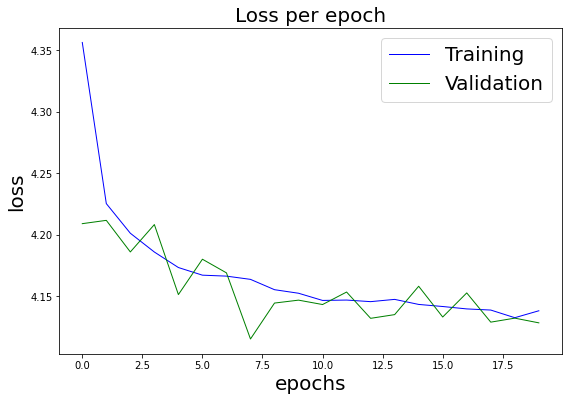

In [28]:
figure(figsize=(9,6))
plt.plot(epoch_count,avg_training_loss, 'b', label = "Training",linewidth = '1')
plt.plot(epoch_count,avg_validation_loss, 'g', label = "Validation",linewidth = '1')



plt.title("Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Training and Validation Accuracy

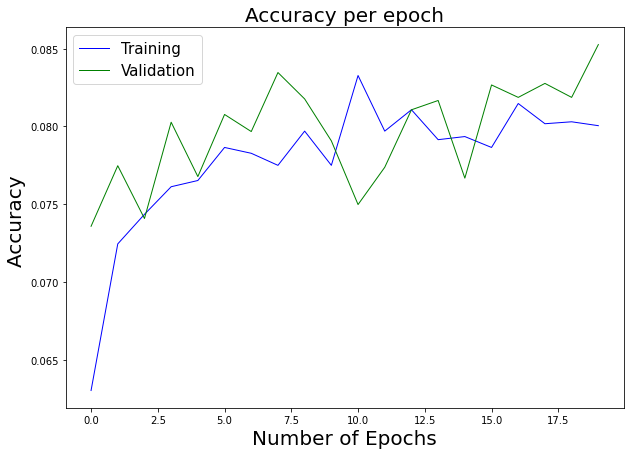

In [26]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_accuracy, 'blue', label = "Training", linewidth = '1')
plt.plot(epoch_count,avg_validation_accuracy, 'green', label = "Validation", linewidth = '1')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=15)
plt.show()

### Test Accuracy

In [27]:
_,test_acc=evaluate(model, test_dl, loss_func)
print('Test Accuracy : ', test_acc*100,' %')

Test Accuracy :  7.907348126173019  %
